# 2. iid Variable Density Sampling

This notebook is intended to demonstrate the interest of using _iid variable density sampling_
either from:
* **optimal distributions** from the CS theory on orthonormal systems for Shannon wavelets derived in:
    -   Chauffert et al, "Variable density compressed sensing in MRI. Theoretical vs heuristic sampling strategies", Proc. 10th IEEE ISBI 2013: 298-301
    -  Chauffert et al, "Variable Density Sampling with Continuous Trajectories" SIAM Imaging Sci, 2014;7(4):1992-1992)

* or from handcrafted densities parameterized by the decay $\eta$:

$$
p(k_x,k_y) =1/\left(k_x^2+k_y^2\right)^{\eta/2}, \quad \eta \simeq 3.
$$

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 06/24/2022
- Target: [IEEE EMBS-SPS Summer School](http://conferences.imt-atlantique.fr/ieeess/index.php?pid=1) on **Novel acquisition and image reconstruction strategies in accelerated Magnetic Resonance Imaging**

## Install dependencies

***On Google Colab, it is required to install the following dependencies in order for the notebook to work***

In [ ]:
!pip install mri-nufft[finufft,gpunufft] pyWavelets pysap-mri brainweb-dl "numpy<2.0" python-pysap 

In [ ]:
# We will also dowload extra data if needed:

(256, 256)


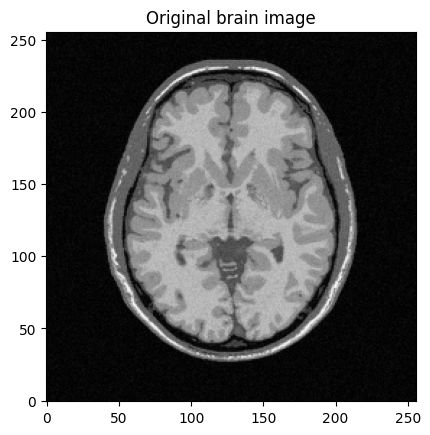

In [13]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import os.path as op
import os
import math
import cmath
import sys

import numpy as np
import pywt as pw
import matplotlib.pyplot as plt

from skimage import data, io, filters
import brainweb_dl as bwdl

plt.rcParams["image.origin"]="lower"
plt.rcParams["image.cmap"]='Greys_r'

# get current working dir
#cwd = os.getcwd()
#dirimg_2d = op.join(cwd,"../data")
#img_size = 512   #256

#load data file corresponding to the target resolution
#filename = "BrainPhantom%s.png" % img_size
#mri_filename = op.join(dirimg_2d, filename)
#mri_img = io.imread(mri_filename)

mri_img = bwdl.get_mri(4, "T1")[70, ...].astype(np.float32)
#mri_img = bwdl.get_mri(4, "T2")[120, ...].astype(np.float32)
print(mri_img.shape)
img_size = mri_img.shape[0]
plt.figure()
plt.imshow(abs(mri_img))
#plt.imshow(abs(mri_2D),origin="lower")
#plt.imshow(abs(mri_2D),origin="upper")
plt.title("Original brain image")
plt.show()


Text(0.5, 1.0, 'Variable density sampling mask')

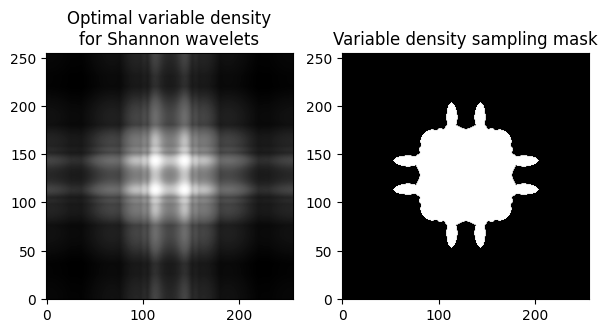

In [14]:
# Load target sampling distribution (precalculated in Matlab)
import numpy as np
from scipy.io import loadmat
import mrinufft.trajectories as mt

# Generate optimal sampoling density for a given wavelet transform, number of resolution levels and img size 
# see details Chauffert et al, IEEE ISBI 2013 for the computation of optimal sampling densities
#opt_density = mt.create_fast_chauffert_density((img_size,img_size),"sym10",3)
opt_density = mt.create_fast_chauffert_density((img_size,img_size),"db4",3)

# Generate Cartesian variable density mask
# change the value below if you want to change the final subsampling mask
threshold = 10. * opt_density.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size, img_size), dtype="float64")
kspace_mask = np.where(opt_density > threshold, 1, kspace_mask)


fig, axs = plt.subplots(1, 2, figsize=(7, 4) )
axs[0].imshow(opt_density)
axs[0].set_title("Optimal variable density\nfor Shannon wavelets")
axs[1].imshow(kspace_mask)
axs[1].set_title("Variable density sampling mask")

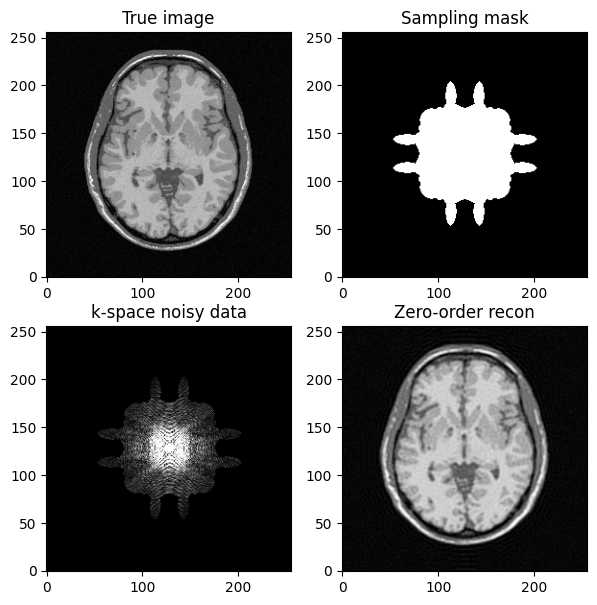

In [15]:
#import numpy.fft as fft

norm = "ortho"
#norm = None

def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
#kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= kspace_mask

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(7, 7) )
axs[0, 0].imshow(mri_img)
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_mask)
axs[0, 1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data), vmax=0.01*np.abs(kspace_data).max())
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(image_rec0))
axs[1, 1].set_title("Zero-order recon")
plt.show()

[[0.22507908 0.22419815 0.22332073 ... 0.22332073 0.22419815 0.22507908]
 [0.22419815 0.22331375 0.22243284 ... 0.22243284 0.22331375 0.22419815]
 [0.22332073 0.22243284 0.22154843 ... 0.22154843 0.22243284 0.22332073]
 ...
 [0.22332073 0.22243284 0.22154843 ... 0.22154843 0.22243284 0.22332073]
 [0.22419815 0.22331375 0.22243284 ... 0.22243284 0.22331375 0.22419815]
 [0.22507908 0.22419815 0.22332073 ... 0.22332073 0.22419815 0.22507908]]


Text(0.5, 1.0, 'VD sampling mask')

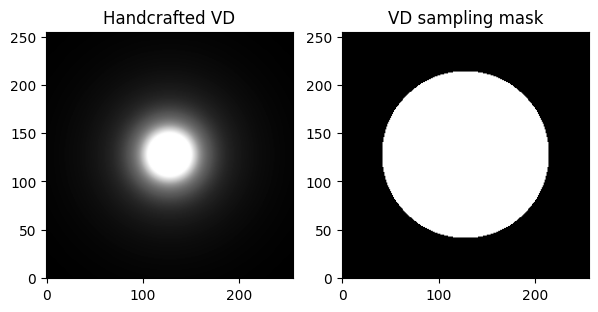

In [11]:
# Now construct by hands a variable sampling distribution
# You can change the decay to modify the decreasing behavior in the center of k-space
# the larger the decay, the faster the decrease from low to high-frequencies
decay = 2
x = np.linspace(-1. / (2. * np.pi), 1. / (2. * np.pi), img_size)
X, Y = np.meshgrid(x, x)
r = np.sqrt(X ** 2 + Y ** 2)
print(r)
p_decay = np.power(r,-decay)
p_decay = p_decay/np.sum(p_decay)

#print(p_decay.max())
#print(p_decay.min())

# change the value below if you want to change the final subsampling mask
threshold = 2* opt_density.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask = np.where(p_decay > threshold, 1, kspace_mask)

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(p_decay, cmap='Greys_r', vmax=0.001 * np.abs(p_decay).max())
axs[0].set_title("Handcrafted VD")
axs[1].imshow(kspace_mask, cmap='Greys_r')
axs[1].set_title("VD sampling mask")

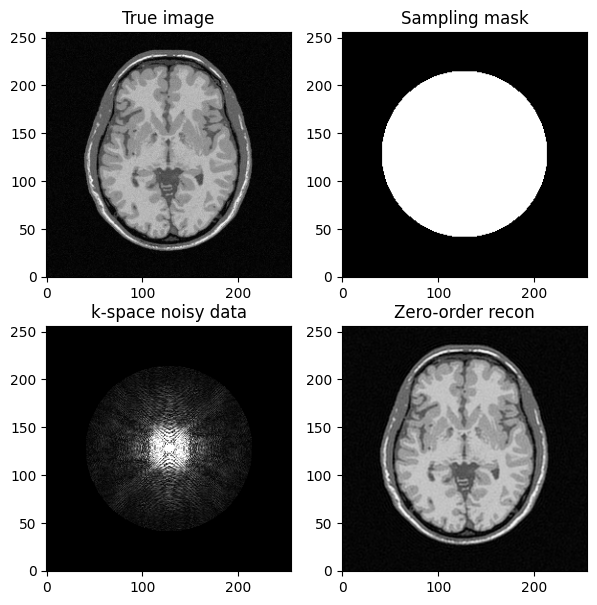

In [12]:
# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
# Simulate independent noise realization on the real & imag parts
kspace_data += (np.random.randn(*mri_img.shape) + 1j * np.random.randn(*mri_img.shape)) * signoise
# Mask data to perform subsampling
kspace_data *= kspace_mask

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].imshow(mri_img, cmap='Greys_r')
axs[0, 0].set_title("True image")
axs[0, 1].imshow(kspace_mask, cmap='Greys_r')
axs[0, 1].set_title("Sampling mask")
axs[1, 0].imshow(np.abs(kspace_data),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1, 0].set_title("k-space noisy data")
axs[1, 1].imshow(np.abs(image_rec0), cmap='Greys_r')
axs[1, 1].set_title("Zero-order recon")
plt.show()